In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC,Precision,Recall
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
trdata = ImageDataGenerator(rescale=1. / 255,rotation_range=10,zoom_range=0.20,shear_range=0,horizontal_flip=False,width_shift_range=0.2,height_shift_range=0.2)
tsdata = ImageDataGenerator(rescale=1. / 255)

traindata = trdata.flow_from_directory(directory="/content/drive/My Drive/chest_xray/train",
                                       target_size=(224,224),
                                       batch_size = 32, 
                                       shuffle=True ,
                                       class_mode = "categorical",
                                       seed=0)

testdata = tsdata.flow_from_directory(directory="/content/drive/My Drive/chest_xray/test",
                                      target_size=(224,224),
                                      batch_size = 32,
                                      shuffle=True ,
                                      class_mode = "categorical",
                                      seed=0)

val_generator= tsdata.flow_from_directory(directory = '/content/drive/My Drive/chest_xray/val',
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          shuffle=True ,
                                          class_mode = "categorical",seed=0)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [3]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced',np.unique(traindata.labels),traindata.labels)

w1 = class_weight[0]
w2 = class_weight[1]

class_weights = {0:w1,1:w2}

print(class_weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [ ]:
# compiling and fitting the model

f_model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['binary_accuracy',
                         AUC(name="auc"),
                         Recall(thresholds=0.5),
                         Precision(thresholds=0.5)])

hist = f_model.fit(traindata,
            shuffle=False, 
            epochs =5,
            class_weight=class_weights,
            steps_per_epoch=len(traindata),
            validation_data=val_generator,
            validation_steps=len(val_generator))

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers

model = VGG16(weights='imagenet', include_top=False)
result = model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)
inception_transfer = Model(inputs=model.input, outputs=predictions)

inception_transfer.compile(loss='categorical_crossentropy',
                           optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                           metrics = ['accuracy',  
                                      AUC(name="auc"),
                                      Recall(thresholds=0.5),
                                      Precision(thresholds=0.5)])


58892288/58889256 [==============================] - 1s 0us/step


In [5]:
inception_transfer.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [7]:
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(traindata,
                                                          epochs=15, 
                                                          shuffle = True, 
                                                          verbose = 1, 
                                                          validation_data = testdata)

Epoch 1/15
163/163 [==============================] - 137s 840ms/step - loss: 0.0861 - accuracy: 0.9689 - auc: 0.9917 - recall: 0.0798 - precision: 0.9976 - val_loss: 0.2223 - val_accuracy: 0.9279 - val_auc: 0.9654 - val_recall: 0.0465 - val_precision: 1.0000
Epoch 2/15
163/163 [==============================] - 136s 832ms/step - loss: 0.0861 - accuracy: 0.9686 - auc: 0.9904 - recall: 0.0704 - precision: 1.0000 - val_loss: 0.2402 - val_accuracy: 0.9231 - val_auc: 0.9611 - val_recall: 0.0481 - val_precision: 1.0000
Epoch 3/15
163/163 [==============================] - 136s 834ms/step - loss: 0.0866 - accuracy: 0.9657 - auc: 0.9918 - recall: 0.0669 - precision: 1.0000 - val_loss: 0.2348 - val_accuracy: 0.9215 - val_auc: 0.9612 - val_recall: 0.0304 - val_precision: 1.0000
Epoch 4/15
163/163 [==============================] - 136s 833ms/step - loss: 0.0854 - accuracy: 0.9686 - auc: 0.9915 - recall: 0.0763 - precision: 1.0000 - val_loss: 0.2381 - val_accuracy: 0.9199 - val_auc: 0.9637 - val

In [8]:
#saving the model
inception_transfer.save('/content/drive/My Drive/chest_xray/vgg16_15_1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/chest_xray/vgg16_15_1/assets


In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np

pred = inception_transfer.predict(testdata)
confusion_matrix(testdata,pred)


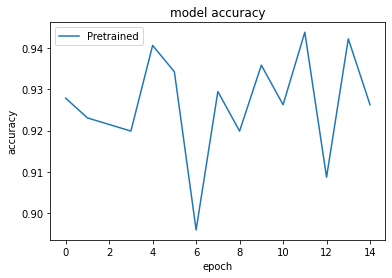

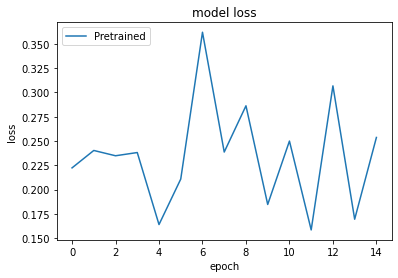

In [11]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()


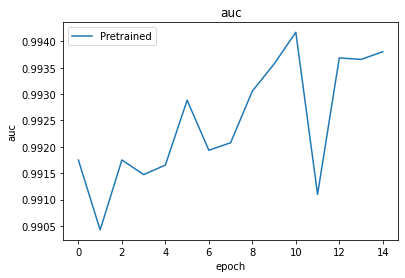

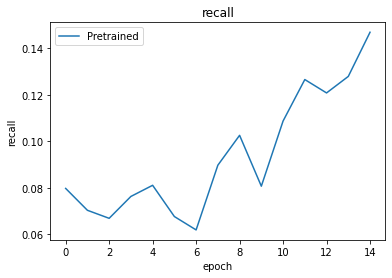

In [12]:
# summarize histtory for auc
plt.plot(history_pretrained.history['auc'])
plt.title('auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()
# summarize histtory for recall
plt.plot(history_pretrained.history['recall'])
plt.title('recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Pretrained'], loc='upper left')
plt.show()